In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = './lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

torch.Size([250, 250, 3])


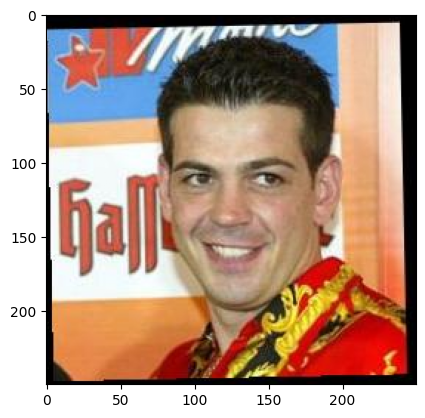

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [6]:
# Get a sample batch from the dataloader
sample_batch, sample_labels = next(iter(dataloader))

# Print dimensions
print("Batch Dimensions:", sample_batch.shape)
print("Label Dimensions:", sample_labels.shape)

Batch Dimensions: torch.Size([32, 3, 250, 250])
Label Dimensions: torch.Size([32])


### Sample Batch Dimensions:

The dimensions of `sample_batch` are `torch.Size([32, 3, 250, 250])`, which means:

- **Batch Size (32):**
  - This is the number of images processed together in a single batch. In this case a batch containing 32 images.

- **Channels (3):**
  - This indicates the number of color channels for each image. A value of 3 typically represents RGB color images.

- **Height (250):**
  - This is the height of each image, representing the number of pixels along the vertical axis.

- **Width (250):**
  - This is the width of each image, representing the number of pixels along the horizontal axis.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [8]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [10]:
# Create an instance of the AE model
model = AE()

# Use the first image from the batch as a sample
sample_image = sample_batch[0:1]  # Extract the first image (1 batch, 3 channels, height, width)

# Pass the sample image through the model
output = model(sample_image)

# Extract encoder and decoder outputs
encoded_output = model.encoder(sample_image)
decoded_output = model.decoder(encoded_output)

# Print the shapes of encoder and decoder outputs
print("Encoder Output Shape:", encoded_output.shape)
print("Decoder Output Shape:", decoded_output.shape)

Encoder Output Shape: torch.Size([1, 128, 32, 32])
Decoder Output Shape: torch.Size([1, 3, 256, 256])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [11]:
# Count the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters: {total_params}")

Total Number of Parameters: 187011


In [12]:
loss_function = nn.MSELoss()

In [13]:
import torch.optim as optim

# Define the optimizer
optim = optim.Adam(model.parameters(), lr=0.001)

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [16]:
num_epochs = 10  # You can adjust this based on your training needs

for epoch in range(num_epochs):
    total_loss = 0.0
    
    for batch_data, _ in dataloader:  # Assuming your DataLoader loads both data and labels
        # Zero the gradients
        optim.zero_grad()
        
        # Forward pass
        outputs = model(batch_data)
        
        # Ensure that outputs and batch_data have the same size
        outputs = outputs[:, :, :batch_data.size(2), :batch_data.size(3)]

        # Compute the loss
        loss = loss_function(outputs, batch_data)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optim.step()
        
        total_loss += loss.item()
    
    # Print average loss at the end of each epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")

Epoch [1/10], Loss: 0.0068295418995135615
Epoch [2/10], Loss: 0.001530848150782665
Epoch [3/10], Loss: 0.001193881868036095
Epoch [4/10], Loss: 0.0010894978911602411
Epoch [5/10], Loss: 0.0010021842729608453
Epoch [6/10], Loss: 0.0009578395329650878
Epoch [7/10], Loss: 0.0008442393065557325
Epoch [8/10], Loss: 0.00078563164083899
Epoch [9/10], Loss: 0.0007933420912252406
Epoch [10/10], Loss: 0.0006611798871657249


### If the loss is not decreasing as expected, I will use the below methods to troubleshoot

### 1. Learning Rate:
   - **Issue:** 
     - High learning rates can cause the model to overshoot the minimum.
     - Low learning rates may result in slow learning.
   - **Solution:** 
     - Experiment with different learning rates to find an optimal value.

### 2. Tune the Model Layers/Complexity:
   - **Issue:** 
     - Overly complex models may overfit and struggle to generalize.
   - **Solution:** 
     - Reducing model complexity by using regularization techniques like dropout.

### 3. Optimizer:
   - **Issue:**
     - Using the same optimizer for different models may not yield a better learning curve and might fail to effectively adapt to the characteristics of each model, hindering its ability to learn from the loss effectively.
   - **Solution:**
     - To address this issue, we should experiment with different optimizers and choose the one that best suits each model.

### 4. Compression:
  - **Issue:**
    - If the input is overly compressed during the encoder phase then model would not be able to reconstruct the image.
  - **Solution:**
    - Experimenting with different compression ratios and monitoring reconstruction quality can help find an optimal setting.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

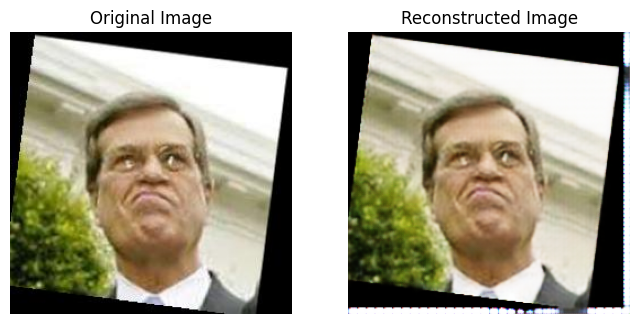

In [19]:
import matplotlib.pyplot as plt
import random

# Set the autoencoder in evaluation mode
model.eval()

# Choose a random image from the dataset
sample_index = random.randint(0, len(dataloader.dataset) - 1)
sample_image, _ = dataloader.dataset[sample_index]

# Add a batch dimension to the sample image
sample_image = sample_image.unsqueeze(0)

# Forward pass through the autoencoder
reconstructed_image = model(sample_image)

# Remove the batch dimension from the reconstructed image
reconstructed_image = reconstructed_image.squeeze(0).detach().numpy()

# Plot the original and reconstructed images
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(sample_image.squeeze(0).permute(1, 2, 0).numpy())  # Assuming the image is in the format (C, H, W)
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image.transpose(1, 2, 0))
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

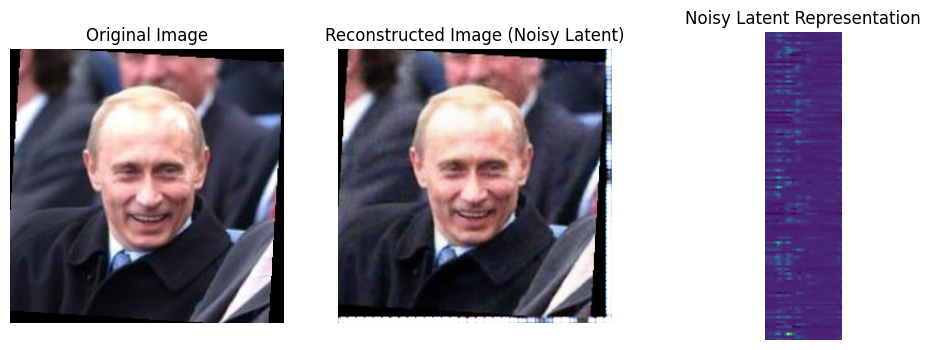

In [23]:
import torch
import matplotlib.pyplot as plt
import random

# Set the autoencoder in evaluation mode
model.eval()

# Choose a random image from the dataset
sample_index = random.randint(0, len(dataloader.dataset) - 1)
sample_image, _ = dataloader.dataset[sample_index]

# Add a batch dimension to the sample image
sample_image = sample_image.unsqueeze(0)

# Forward pass through the encoder to get the latent representation
latent_representation = model.encoder(sample_image)

# Add small normally distributed noise to the latent representation
noise = torch.randn_like(latent_representation) * 0.2  # You can adjust the scale of the noise
noisy_latent_representation = latent_representation + noise

# Forward pass through the decoder with the noisy latent representation
reconstructed_image_with_noise = model.decoder(noisy_latent_representation)

# Remove the batch dimension from the tensors for plotting
sample_image = sample_image.squeeze(0).permute(1, 2, 0).numpy()
reconstructed_image_with_noise = reconstructed_image_with_noise.squeeze(0).permute(1, 2, 0).detach().numpy()

# Plot the original and reconstructed images with noise
plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image)
plt.axis('off')

# Reconstructed Image (Noisy Latent)
plt.subplot(1, 3, 2)
plt.title("Reconstructed Image (Noisy Latent)")
plt.imshow(reconstructed_image_with_noise)
plt.axis('off')

# Choose a specific channel or slice of channels from the noisy latent representation for visualization
channel_to_visualize = 0
latent_channel = noisy_latent_representation.squeeze(0).detach().numpy()[:, :, channel_to_visualize]

# Latent Representation (Noisy)
plt.subplot(1, 3, 3)
plt.title("Noisy Latent Representation")
plt.imshow(latent_channel)
plt.axis('off')

plt.show()


## How is adding noise affecting the decoded image ?

### Regularization:
Adding a bit of random noise to the latent representation during reconstruction helps the model avoid memorizing the training data too precisely. This prevents overfitting, allowing the model to perform better on new, unseen examples.

### Variability in Reconstruction:
The reconstructed image, when noise is added to the latent representation, might look a bit different each time. This variation disrupts the meaningful patterns the encoder has captured, leading to distortions in the reconstructed output.